In [1]:
from GameEnv import Game2048
# gameEnv = Game2048(4,"score")
# gameEnv.grid_n = 4

In [2]:
# 策略迭代测试
def check_one_game_with_model(gameEnv,model,debug):
    gameEnv.reset()
    observation = copy.deepcopy(gameEnv.matrix)
    while True:
        action = random.choice(["a","s","d","w"])
        observation_, reward, done = gameEnv.step(action)
        observation = copy.deepcopy(observation_)
        if done:
            break
    return gameEnv.score

+ 选择 Selection：从根节点 R 开始，递归选择最优的子节点（后面会解释）直到达到叶子节点 L。
+ 扩展 Expansion：如果 L 不是一个终止节点（也就是，不会导致博弈游戏终止）那么就创建一个或者更多的字子节点，选择其中一个 C。
+ 模拟 Simulation：从 C 开始运行一个模拟的输出，直到博弈游戏结束。
+ 反向传播 Backpropagation：用模拟的结果输出更新当前行动序列。

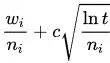

+ wi：第 i 次移动后取胜的次数
+ ni：第 i 次移动后仿真的次数
+ c：探索参数/权衡参数，理论上等于 根号2，在实际中通常可凭经验选择
+ t：仿真总次数，等于所有 ni 的和

In [3]:
import numpy as np
class Node:
    def __init__(self,matrix):
        self.matrix = matrix
        self.n = 0
        self.score = 0.0
        self.max_score = 0.0
        self.children_dict = {
            "a":[],
            "s":[],
            "w":[],
            "d":[]
        }

class MCTS:
    def __init__(self):
        self.node_dict = {}
        self.gameEnv = Game2048()
        self.gameEnv.grid_n = 4
        self.ucb_debug = True
        self.predict_debug = True
        self.search_debug = True
        self.search_n = 200
    
    def search(self,matrix=None):
        for i in range(self.search_n):
            if self.search_debug:
                if str(matrix) in self.node_dict:
                    print "matrix:",matrix
                    print "matrix_num:",self.node_dict[str(matrix)].n
                    print "children:",self.node_dict[str(matrix)].children_dict
            if matrix == None:
                self.gameEnv.reset()
            else:
                self.gameEnv.reset(copy.deepcopy(matrix))
            sum_score = 0
            node_list = []
            while True:
                tmp = copy.deepcopy(self.gameEnv.matrix)
                if str(self.gameEnv.matrix) in self.node_dict:
                    cur_node = self.node_dict[str(self.gameEnv.matrix)]
                else:
                    cur_node = Node(copy.deepcopy(self.gameEnv.matrix))
                    self.node_dict[str(self.gameEnv.matrix)] = cur_node
                observation_next,reward,action,done = self.select(cur_node)
                if self.search_debug:
                    print "action:",done,action,cur_node.matrix
                if observation_next == tmp and done is False:
                    cur_node.children_dict[action] = -1
                    continue
                else:
                    if str(observation_next) in cur_node.children_dict[action]: 
                        pass
                    elif len(cur_node.children_dict[action]) == 0:
                        cur_node.children_dict[action] = [str(observation_next)]
                    else:
                        cur_node.children_dict[action].append(str(observation_next))
                sum_score += reward
                node_list.append(cur_node)
                if done:
                    break
                    
            # 反向计算值
#             print "node_list:",len(node_list)
            for node in set(node_list):
#                 print sum_score,node.n
                node.score = (node.score * node.n + sum_score) / (node.n + 1)
                node.max_score = max(node.max_score,sum_score)
                node.n += 1
                
    
    def ucb(self,node):
        for action in ["a","s","w","d"]:
            if node.children_dict[action] == -1:continue
            if len(node.children_dict[action]) == 0:
                return action
#         print node.children_dict["a"]
#         print node.children_dict["s"]
#         print node.children_dict["w"]
#         print node.children_dict["d"]
        w_i = []
        n_i = []
        for a in ["a","s","w","d"]:
            if node.children_dict[a] != -1:
                w_i.append(np.sum([self.node_dict[i].score for i in node.children_dict[a]]))
                n_i.append(np.sum([self.node_dict[i].n for i in node.children_dict[a]]))
            else:
                w_i.append(-1)
                n_i.append(1)

        t = np.sum(n_i)
        
        c = 100
        score_i = []
        for i in range(4):
            if w_i[i] == -1:
                score_i.append(-1)
            else:
                score_i.append(w_i[i] / n_i[i] + c * np.sqrt(np.log(t) / n_i[i]))
        if self.ucb_debug:
            print w_i
            print n_i
            print score_i
            print node.matrix
            print "****************************"
        l = ["a","s","w","d"]
        index = np.argmax(score_i)
        return l[index]
    
    def select(self,node):
        # expand 
        action = self.ucb(node)
            
        observation_, reward, done = self.gameEnv.step(action)
        return observation_,reward,action,done
        
            
    def predict(self,matrix):
        if str(matrix) not in self.node_dict:
            self.search(copy.deepcopy(matrix))
        node = self.node_dict[str(matrix)]
        for action in ["a","s","w","d"]:
            if node.children_dict[action] == -1:
                continue
                if len(node.children_dict[action]) == 0:
                    self.search(copy.deepcopy(matrix))
                    break

#         print "predict start"
        w_i = []
        n_i = []
        for a in ["a","s","w","d"]:
            if node.children_dict[a] != -1:
                w_i.append(np.sum([self.node_dict[i].score for i in node.children_dict[a]]))
#                 n_i.append(np.sum([self.node_dict[i].n for i in node.children_dict[a]]))
                n_i.append(len(node.children_dict[a]))
            else:
                w_i.append(0)
                n_i.append(1)

        score_i = []
        for i in range(4):
            score_i.append(w_i[i] / n_i[i])
        if self.predict_debug:
            print w_i
            print n_i
            print score_i
            
        l = ["a","s","w","d"]
        index = np.argmax(score_i)
        return l[index]

In [19]:
mcts = MCTS()
mcts.ucb_debug = False
mcts.predict_debug = False
mcts.search_debug = False
mcts.search_n = 5

In [25]:
# 策略迭代测试
import copy
import random
def check_one_game_with_model(model,debug):
    gameEnv = Game2048()
    gameEnv.reset([[0,0,0,0],[2,0,0,0],[0,0,0,2],[0,0,0,0]])
    observation = copy.deepcopy(gameEnv.matrix)
    while True:
        if debug:gameEnv.display()
        action = random.choice(["s","d","a","w"])
#         if False == (str(observation) in mcts.node_dict and mcts.node_dict[str(observation)].n > 20):
#             model.search(observation)
#         else:
#             print "not search"
#         action = model.predict(observation)
        observation_, reward, done = gameEnv.step(action)
        observation = copy.deepcopy(observation_)
        if debug:print("_________________________________________")
        if done:
            if debug:gameEnv.display()
            if debug:print("this_score_____________________:",gameEnv.score)
            break
    return gameEnv.score

In [26]:
import time
start = time.time()
mcts.search_n = 1
for i in range(5):
    check_one_game_with_model(mcts,False)
print time.time() - start

0.122889041901


In [6]:
status = [[8, 16, 128, 4], [4, 256, 32, 8], [64, 64, 4, 2], [4, 8, 2, 4]]
8	 16	 128	 4	 

4	 256	 32	 8	 

32	 2	 -	 -	 

2	 8	 2	 4	 


In [7]:
mcts.search(status)

action: False a [[4, 0, 0, 0], [2048, 0, 0, 0], [64, 64, 4, 2], [4, 8, 2, 4]]
action: False a [[4, 0, 4, 0], [2048, 0, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]
action: False a [[8, 0, 0, 0], [2048, 0, 4, 0], [128, 4, 2, 0], [4, 8, 2, 4]]
action: False a [[8, 0, 0, 4], [2048, 4, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]
action: False a [[8, 4, 0, 0], [2048, 4, 2, 0], [128, 4, 2, 0], [4, 8, 2, 4]]
action: False s [[8, 4, 0, 0], [2048, 4, 2, 0], [128, 4, 2, 0], [4, 8, 2, 4]]
action: False a [[8, 0, 2, 0], [2048, 8, 0, 0], [128, 4, 4, 0], [4, 8, 2, 4]]
action: False a [[8, 2, 0, 0], [2048, 8, 0, 0], [128, 8, 4, 0], [4, 8, 2, 4]]
action: False s [[8, 2, 0, 0], [2048, 8, 0, 0], [128, 8, 4, 0], [4, 8, 2, 4]]
action: False a [[8, 0, 0, 0], [2048, 2, 0, 2], [128, 16, 4, 0], [4, 8, 2, 4]]
action: False a [[8, 0, 0, 0], [2048, 4, 0, 4], [128, 16, 4, 0], [4, 8, 2, 4]]
action: False a [[8, 0, 0, 0], [2048, 8, 2, 0], [128, 16, 4, 0], [4, 8, 2, 4]]
action: False s [[8, 0, 0, 0], [2048, 8, 2, 0], [128, 16, 4, 

action: False a [[2, 8, 0, 0], [2048, 8, 4, 0], [128, 32, 0, 0], [4, 0, 4, 0]]
action: False a [[2, 8, 0, 4], [2048, 8, 4, 0], [128, 32, 0, 0], [8, 0, 0, 0]]
action: False a [[2, 8, 4, 0], [2048, 8, 4, 0], [128, 32, 0, 2], [8, 0, 0, 0]]
action: False a [[2, 8, 4, 0], [2048, 8, 4, 0], [128, 32, 2, 0], [8, 0, 0, 2]]
action: False a [[2, 8, 4, 0], [2048, 8, 4, 0], [128, 32, 2, 0], [8, 2, 2, 0]]
action: False a [[2, 8, 4, 2], [2048, 8, 4, 0], [128, 32, 2, 0], [8, 4, 0, 0]]
action: False s [[2, 8, 4, 2], [2048, 8, 4, 0], [128, 32, 2, 0], [8, 4, 0, 0]]
action: False a [[2, 0, 0, 0], [2048, 16, 0, 2], [128, 32, 8, 0], [8, 4, 2, 2]]
action: False a [[2, 4, 0, 0], [2048, 16, 2, 0], [128, 32, 8, 0], [8, 4, 4, 0]]
action: False a [[2, 4, 0, 0], [2048, 16, 2, 0], [128, 32, 8, 0], [8, 8, 4, 0]]
action: False a [[2, 4, 0, 0], [2048, 16, 2, 2], [128, 32, 8, 0], [16, 4, 0, 0]]
action: False a [[2, 4, 0, 0], [2048, 16, 4, 0], [128, 32, 8, 0], [16, 4, 0, 2]]
action: False a [[2, 4, 0, 0], [2048, 16, 4, 

action: False s [[4, 2, 4, 8], [2048, 8, 0, 0], [128, 8, 2, 0], [8, 2, 4, 0]]
action: False a [[4, 0, 0, 0], [2048, 2, 4, 0], [128, 16, 2, 4], [8, 2, 4, 8]]
action: False s [[4, 0, 0, 0], [2048, 2, 4, 0], [128, 16, 2, 4], [8, 2, 4, 8]]
action: False w [[4, 0, 0, 0], [2048, 2, 4, 0], [128, 16, 2, 4], [8, 2, 4, 8]]
action: False a [[4, 2, 4, 4], [2048, 16, 2, 8], [128, 2, 4, 0], [8, 0, 0, 4]]
action: False a [[4, 2, 8, 0], [2048, 16, 2, 8], [128, 2, 4, 0], [8, 4, 2, 0]]
action: False s [[4, 2, 8, 0], [2048, 16, 2, 8], [128, 2, 4, 0], [8, 4, 2, 0]]
action: False a [[4, 2, 8, 0], [2048, 16, 2, 0], [128, 2, 4, 2], [8, 4, 2, 8]]
action: False s [[4, 2, 8, 0], [2048, 16, 2, 0], [128, 2, 4, 2], [8, 4, 2, 8]]
action: False w [[4, 2, 8, 0], [2048, 16, 2, 0], [128, 2, 4, 2], [8, 4, 2, 8]]
action: False a [[4, 2, 8, 2], [2048, 16, 2, 8], [128, 2, 4, 0], [8, 4, 2, 2]]
action: False a [[4, 2, 8, 2], [2048, 16, 2, 8], [128, 2, 4, 2], [8, 4, 4, 0]]
action: False a [[4, 2, 8, 2], [2048, 16, 2, 8], [128

action: False a [[4, 0, 0, 2], [2048, 0, 0, 0], [128, 4, 4, 0], [4, 8, 4, 4]]
action: False a [[4, 2, 0, 0], [2048, 0, 0, 0], [128, 8, 2, 0], [4, 8, 8, 0]]
action: False a [[4, 2, 0, 0], [2048, 0, 4, 0], [128, 8, 2, 0], [4, 16, 0, 0]]
action: False a [[4, 2, 4, 0], [2048, 4, 0, 0], [128, 8, 2, 0], [4, 16, 0, 0]]
action: False s [[4, 2, 4, 0], [2048, 4, 0, 0], [128, 8, 2, 0], [4, 16, 0, 0]]
action: False a [[4, 2, 0, 0], [2048, 4, 0, 0], [128, 8, 4, 0], [4, 16, 2, 4]]
action: False s [[4, 2, 0, 0], [2048, 4, 0, 0], [128, 8, 4, 0], [4, 16, 2, 4]]
action: False w [[4, 2, 0, 0], [2048, 4, 0, 0], [128, 8, 4, 0], [4, 16, 2, 4]]
action: False a [[4, 2, 4, 4], [2048, 4, 2, 0], [128, 8, 0, 0], [4, 16, 2, 0]]
action: False a [[4, 2, 8, 4], [2048, 4, 2, 0], [128, 8, 0, 0], [4, 16, 2, 0]]
action: False s [[4, 2, 8, 4], [2048, 4, 2, 0], [128, 8, 0, 0], [4, 16, 2, 0]]
action: False a [[4, 2, 0, 0], [2048, 4, 0, 4], [128, 8, 8, 0], [4, 16, 4, 4]]
action: False a [[4, 2, 0, 0], [2048, 8, 0, 4], [128, 

action: False a [[4, 64, 8, 2], [2048, 16, 4, 0], [64, 2, 16, 4], [8, 4, 2, 16]]
action: False s [[4, 64, 8, 2], [2048, 16, 4, 0], [64, 2, 16, 4], [8, 4, 2, 16]]
action: True a [[4, 64, 8, 4], [2048, 16, 4, 2], [64, 2, 16, 4], [8, 4, 2, 16]]
matrix: [[4, 0, 0, 0], [2048, 0, 0, 0], [64, 64, 4, 2], [4, 8, 2, 4]]
matrix_num: 10
children: {'a': ['[[4, 0, 4, 0], [2048, 0, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 0, 0], [128, 4, 2, 4], [4, 8, 2, 4]]'], 's': -1, 'd': ['[[2, 0, 0, 4], [0, 0, 0, 2048], [0, 128, 4, 2], [4, 8, 2, 4]]', '[[0, 0, 0, 4], [4, 0, 0, 2048], [0, 128, 4, 2], [4, 8, 2, 4]]'], 'w': ['[[4, 64, 4, 2], [2048, 8, 2, 4], [64, 0, 0, 0], [4, 2, 0, 0]]', '[[4, 64, 4, 2], [2048, 8, 2, 4], [64, 0, 4, 0], [4, 0, 0, 0]]', '[[4, 64, 4, 2], [2048, 8, 2, 4], [64, 0, 0, 0], [4, 0, 4, 0]]', '[[4, 64, 4, 2], [2048, 8, 2, 4], [64, 0, 0, 0], [4, 0, 0, 4]]']}
[67.53513648200745, -1, 133.2139818807628, 62.21565851424984]
[3, 1, 4, 3]
[111.91520338255172, -1, 110.72919005

action: False a [[8, 2, 0, 0], [32, 2, 0, 0], [128, 2048, 8, 0], [4, 64, 4, 2]]
action: False s [[8, 2, 0, 0], [32, 2, 0, 0], [128, 2048, 8, 0], [4, 64, 4, 2]]
action: False a [[8, 0, 4, 0], [32, 4, 0, 0], [128, 2048, 8, 0], [4, 64, 4, 2]]
action: False a [[8, 4, 0, 4], [32, 4, 0, 0], [128, 2048, 8, 0], [4, 64, 4, 2]]
action: False a [[8, 8, 0, 2], [32, 4, 0, 0], [128, 2048, 8, 0], [4, 64, 4, 2]]
action: False a [[16, 2, 2, 0], [32, 4, 0, 0], [128, 2048, 8, 0], [4, 64, 4, 2]]
action: False a [[16, 4, 0, 0], [32, 4, 0, 0], [128, 2048, 8, 2], [4, 64, 4, 2]]
action: False s [[16, 4, 0, 0], [32, 4, 0, 0], [128, 2048, 8, 2], [4, 64, 4, 2]]
action: False a [[16, 0, 0, 0], [32, 8, 0, 2], [128, 2048, 8, 0], [4, 64, 4, 4]]
action: False a [[16, 4, 0, 0], [32, 8, 2, 0], [128, 2048, 8, 0], [4, 64, 8, 0]]
action: False s [[16, 4, 0, 0], [32, 8, 2, 0], [128, 2048, 8, 0], [4, 64, 8, 0]]
action: False a [[16, 4, 0, 0], [32, 8, 4, 0], [128, 2048, 2, 0], [4, 64, 16, 0]]
action: False s [[16, 4, 0, 0], 

action: False a [[16, 0, 2, 0], [2048, 4, 4, 2], [128, 8, 8, 2], [4, 64, 16, 4]]
action: False a [[16, 2, 0, 0], [2048, 8, 2, 4], [128, 16, 2, 0], [4, 64, 16, 4]]
action: False s [[16, 2, 0, 0], [2048, 8, 2, 4], [128, 16, 2, 0], [4, 64, 16, 4]]
action: False a [[16, 2, 0, 0], [2048, 8, 0, 0], [128, 16, 4, 4], [4, 64, 16, 8]]
action: False a [[16, 2, 0, 0], [2048, 8, 4, 0], [128, 16, 8, 0], [4, 64, 16, 8]]
action: False s [[16, 2, 0, 0], [2048, 8, 4, 0], [128, 16, 8, 0], [4, 64, 16, 8]]
action: False w [[16, 2, 0, 0], [2048, 8, 4, 0], [128, 16, 8, 0], [4, 64, 16, 8]]
action: False a [[16, 2, 4, 8], [2048, 8, 8, 0], [128, 16, 16, 4], [4, 64, 0, 0]]
action: False a [[16, 2, 4, 8], [2048, 16, 4, 0], [128, 32, 4, 0], [4, 64, 0, 0]]
action: False s [[16, 2, 4, 8], [2048, 16, 4, 0], [128, 32, 4, 0], [4, 64, 0, 0]]
action: False a [[16, 2, 0, 2], [2048, 16, 0, 0], [128, 32, 8, 0], [4, 64, 4, 8]]
action: False a [[16, 4, 0, 4], [2048, 16, 0, 0], [128, 32, 8, 0], [4, 64, 4, 8]]
action: False a [

action: False a [[8, 2, 8, 0], [2048, 4, 4, 0], [128, 16, 0, 0], [4, 64, 0, 0]]
action: False a [[8, 2, 8, 0], [2048, 8, 0, 0], [128, 16, 0, 0], [4, 64, 2, 0]]
action: False s [[8, 2, 8, 0], [2048, 8, 0, 0], [128, 16, 0, 0], [4, 64, 2, 0]]
action: False a [[8, 2, 0, 4], [2048, 8, 0, 0], [128, 16, 8, 0], [4, 64, 2, 0]]
action: False a [[8, 2, 4, 0], [2048, 8, 0, 0], [128, 16, 8, 4], [4, 64, 2, 0]]
action: False s [[8, 2, 4, 0], [2048, 8, 0, 0], [128, 16, 8, 4], [4, 64, 2, 0]]
action: False a [[8, 2, 2, 0], [2048, 8, 4, 0], [128, 16, 8, 0], [4, 64, 2, 4]]
action: False a [[8, 4, 0, 4], [2048, 8, 4, 0], [128, 16, 8, 0], [4, 64, 2, 4]]
action: False a [[8, 8, 2, 0], [2048, 8, 4, 0], [128, 16, 8, 0], [4, 64, 2, 4]]
action: False a [[16, 2, 0, 0], [2048, 8, 4, 0], [128, 16, 8, 2], [4, 64, 2, 4]]
action: False s [[16, 2, 0, 0], [2048, 8, 4, 0], [128, 16, 8, 2], [4, 64, 2, 4]]
action: False w [[16, 2, 0, 0], [2048, 8, 4, 0], [128, 16, 8, 2], [4, 64, 2, 4]]
action: False a [[16, 2, 4, 2], [2048

action: False s [[128, 0, 0, 0], [2, 8, 2, 0], [8, 16, 2048, 4], [16, 4, 8, 4]]
action: False a [[128, 0, 0, 0], [2, 8, 2, 0], [8, 16, 2048, 4], [16, 4, 8, 8]]
action: False a [[128, 0, 0, 2], [2, 8, 2, 0], [8, 16, 2048, 4], [16, 4, 16, 0]]
action: False a [[128, 2, 0, 4], [2, 8, 2, 0], [8, 16, 2048, 4], [16, 4, 16, 0]]
action: False a [[128, 2, 4, 0], [2, 8, 2, 0], [8, 16, 2048, 4], [16, 4, 16, 4]]
action: False s [[128, 2, 4, 0], [2, 8, 2, 0], [8, 16, 2048, 4], [16, 4, 16, 4]]
action: False a [[128, 2, 4, 4], [2, 8, 2, 0], [8, 16, 2048, 0], [16, 4, 16, 8]]
action: False a [[128, 2, 8, 0], [2, 8, 2, 0], [8, 16, 2048, 4], [16, 4, 16, 8]]
action: False s [[128, 2, 8, 0], [2, 8, 2, 0], [8, 16, 2048, 4], [16, 4, 16, 8]]
action: False w [[128, 2, 8, 0], [2, 8, 2, 0], [8, 16, 2048, 4], [16, 4, 16, 8]]
action: False a [[128, 2, 8, 4], [2, 8, 2, 8], [8, 16, 2048, 2], [16, 4, 16, 0]]
action: False s [[128, 2, 8, 4], [2, 8, 2, 8], [8, 16, 2048, 2], [16, 4, 16, 0]]
action: True a [[128, 2, 8, 2]

action: False s [[32, 8, 0, 0], [2048, 16, 8, 4], [128, 64, 8, 0], [64, 4, 64, 8]]
action: False a [[32, 8, 0, 4], [2048, 16, 0, 0], [128, 64, 16, 4], [64, 4, 64, 8]]
action: False a [[32, 8, 4, 2], [2048, 16, 0, 0], [128, 64, 16, 4], [64, 4, 64, 8]]
action: False s [[32, 8, 4, 2], [2048, 16, 0, 0], [128, 64, 16, 4], [64, 4, 64, 8]]
action: False a [[32, 8, 2, 0], [2048, 16, 4, 2], [128, 64, 16, 4], [64, 4, 64, 8]]
action: False s [[32, 8, 2, 0], [2048, 16, 4, 2], [128, 64, 16, 4], [64, 4, 64, 8]]
action: False w [[32, 8, 2, 0], [2048, 16, 4, 2], [128, 64, 16, 4], [64, 4, 64, 8]]
action: False a [[32, 8, 2, 2], [2048, 16, 4, 4], [128, 64, 16, 8], [64, 4, 64, 2]]
action: False a [[32, 8, 4, 0], [2048, 16, 8, 2], [128, 64, 16, 8], [64, 4, 64, 2]]
action: False s [[32, 8, 4, 0], [2048, 16, 8, 2], [128, 64, 16, 8], [64, 4, 64, 2]]
action: False w [[32, 8, 4, 0], [2048, 16, 8, 2], [128, 64, 16, 8], [64, 4, 64, 2]]
action: False a [[32, 8, 4, 2], [2048, 16, 8, 8], [128, 64, 16, 2], [64, 4, 6

action: False a [[16, 4, 0, 0], [64, 16, 0, 2], [128, 2048, 8, 2], [8, 16, 8, 2]]
action: False a [[16, 4, 0, 0], [64, 16, 2, 4], [128, 2048, 8, 2], [8, 16, 8, 2]]
action: False s [[16, 4, 0, 0], [64, 16, 2, 4], [128, 2048, 8, 2], [8, 16, 8, 2]]
action: False a [[16, 4, 0, 0], [64, 16, 0, 2], [128, 2048, 2, 4], [8, 16, 16, 4]]
action: False a [[16, 4, 0, 0], [64, 16, 2, 0], [128, 2048, 2, 4], [8, 32, 4, 4]]
action: False a [[16, 4, 0, 0], [64, 16, 2, 0], [128, 2048, 2, 4], [8, 32, 8, 4]]
action: False s [[16, 4, 0, 0], [64, 16, 2, 0], [128, 2048, 2, 4], [8, 32, 8, 4]]
action: False a [[16, 4, 0, 0], [64, 16, 0, 0], [128, 2048, 4, 2], [8, 32, 8, 8]]
action: False a [[16, 4, 2, 0], [64, 16, 0, 0], [128, 2048, 4, 2], [8, 32, 16, 0]]
action: False s [[16, 4, 2, 0], [64, 16, 0, 0], [128, 2048, 4, 2], [8, 32, 16, 0]]
action: False a [[16, 4, 0, 4], [64, 16, 2, 0], [128, 2048, 4, 0], [8, 32, 16, 2]]
action: False a [[16, 8, 4, 0], [64, 16, 2, 0], [128, 2048, 4, 0], [8, 32, 16, 2]]
action: Fal

action: False a [[0, 2, 0, 0], [4, 4, 0, 0], [2048, 128, 8, 0], [16, 2, 8, 0]]
action: False a [[2, 0, 2, 0], [8, 0, 0, 0], [2048, 128, 8, 0], [16, 2, 8, 0]]
action: False a [[4, 0, 0, 0], [8, 0, 4, 0], [2048, 128, 8, 0], [16, 2, 8, 0]]
action: False a [[4, 2, 0, 0], [8, 4, 0, 0], [2048, 128, 8, 0], [16, 2, 8, 0]]
action: False s [[4, 2, 0, 0], [8, 4, 0, 0], [2048, 128, 8, 0], [16, 2, 8, 0]]
action: False a [[4, 2, 2, 0], [8, 4, 0, 0], [2048, 128, 0, 0], [16, 2, 16, 0]]
action: False a [[4, 4, 0, 0], [8, 4, 0, 2], [2048, 128, 0, 0], [16, 2, 16, 0]]
action: False a [[8, 0, 0, 0], [8, 4, 2, 0], [2048, 128, 2, 0], [16, 2, 16, 0]]
action: False s [[8, 0, 0, 0], [8, 4, 2, 0], [2048, 128, 2, 0], [16, 2, 16, 0]]
action: False a [[0, 0, 0, 2], [16, 4, 0, 0], [2048, 128, 4, 0], [16, 2, 16, 0]]
action: False a [[2, 4, 0, 0], [16, 4, 0, 0], [2048, 128, 4, 0], [16, 2, 16, 0]]
action: False s [[2, 4, 0, 0], [16, 4, 0, 0], [2048, 128, 4, 0], [16, 2, 16, 0]]
action: False a [[2, 0, 0, 2], [16, 8, 0, 

action: False a [[16, 8, 4, 2], [2048, 32, 16, 0], [128, 16, 8, 4], [4, 64, 32, 2]]
action: False s [[16, 8, 4, 2], [2048, 32, 16, 0], [128, 16, 8, 4], [4, 64, 32, 2]]
action: False a [[16, 8, 4, 2], [2048, 32, 16, 2], [128, 16, 8, 4], [4, 64, 32, 2]]
action: False s [[16, 8, 4, 2], [2048, 32, 16, 2], [128, 16, 8, 4], [4, 64, 32, 2]]
action: False a [[16, 8, 4, 2], [2048, 32, 16, 4], [128, 16, 8, 4], [4, 64, 32, 2]]
action: False s [[16, 8, 4, 2], [2048, 32, 16, 4], [128, 16, 8, 4], [4, 64, 32, 2]]
action: False a [[16, 8, 4, 2], [2048, 32, 16, 2], [128, 16, 8, 8], [4, 64, 32, 2]]
action: False a [[16, 8, 4, 2], [2048, 32, 16, 2], [128, 16, 16, 4], [4, 64, 32, 2]]
action: False a [[16, 8, 4, 2], [2048, 32, 16, 2], [128, 32, 4, 2], [4, 64, 32, 2]]
action: False s [[16, 8, 4, 2], [2048, 32, 16, 2], [128, 32, 4, 2], [4, 64, 32, 2]]
action: False a [[16, 0, 4, 0], [2048, 8, 16, 4], [128, 64, 4, 4], [4, 64, 32, 4]]
action: False a [[16, 4, 2, 0], [2048, 8, 16, 4], [128, 64, 8, 0], [4, 64, 3

action: False s [[32, 2, 8, 0], [2048, 8, 2, 0], [128, 32, 8, 2], [4, 128, 32, 0]]
action: False a [[32, 2, 8, 0], [2048, 8, 2, 0], [128, 32, 8, 4], [4, 128, 32, 2]]
action: False s [[32, 2, 8, 0], [2048, 8, 2, 0], [128, 32, 8, 4], [4, 128, 32, 2]]
action: False w [[32, 2, 8, 0], [2048, 8, 2, 0], [128, 32, 8, 4], [4, 128, 32, 2]]
action: False a [[32, 2, 8, 4], [2048, 8, 2, 2], [128, 32, 8, 4], [4, 128, 32, 0]]
action: False a [[32, 2, 8, 4], [2048, 8, 4, 0], [128, 32, 8, 4], [4, 128, 32, 2]]
action: False s [[32, 2, 8, 4], [2048, 8, 4, 0], [128, 32, 8, 4], [4, 128, 32, 2]]
action: False a [[32, 2, 8, 2], [2048, 8, 4, 0], [128, 32, 8, 8], [4, 128, 32, 2]]
action: False a [[32, 2, 8, 2], [2048, 8, 4, 4], [128, 32, 16, 0], [4, 128, 32, 2]]
action: False a [[32, 2, 8, 2], [2048, 8, 8, 2], [128, 32, 16, 0], [4, 128, 32, 2]]
action: False a [[32, 2, 8, 2], [2048, 16, 2, 0], [128, 32, 16, 2], [4, 128, 32, 2]]
action: False s [[32, 2, 8, 2], [2048, 16, 2, 0], [128, 32, 16, 2], [4, 128, 32, 2]

action: False a [[16, 4, 0, 0], [2048, 16, 0, 0], [128, 32, 16, 2], [4, 128, 4, 4]]
action: False a [[16, 4, 0, 2], [2048, 16, 0, 0], [128, 32, 16, 2], [4, 128, 8, 0]]
action: False a [[16, 4, 2, 0], [2048, 16, 0, 4], [128, 32, 16, 2], [4, 128, 8, 0]]
action: False a [[16, 4, 2, 0], [2048, 16, 4, 0], [128, 32, 16, 2], [4, 128, 8, 4]]
action: False s [[16, 4, 2, 0], [2048, 16, 4, 0], [128, 32, 16, 2], [4, 128, 8, 4]]
action: False w [[16, 4, 2, 0], [2048, 16, 4, 0], [128, 32, 16, 2], [4, 128, 8, 4]]
action: False a [[16, 4, 2, 2], [2048, 16, 4, 4], [128, 32, 16, 2], [4, 128, 8, 0]]
action: False a [[16, 4, 4, 0], [2048, 16, 8, 0], [128, 32, 16, 2], [4, 128, 8, 2]]
action: False a [[16, 8, 0, 0], [2048, 16, 8, 4], [128, 32, 16, 2], [4, 128, 8, 2]]
action: False s [[16, 8, 0, 0], [2048, 16, 8, 4], [128, 32, 16, 2], [4, 128, 8, 2]]
action: False a [[16, 8, 0, 4], [2048, 16, 8, 0], [128, 32, 16, 4], [4, 128, 8, 4]]
action: False a [[16, 8, 4, 2], [2048, 16, 8, 0], [128, 32, 16, 4], [4, 128,

action: False a [[32, 4, 2, 0], [2048, 16, 16, 8], [128, 32, 16, 8], [2, 64, 32, 4]]
action: False a [[32, 4, 2, 0], [2048, 32, 8, 4], [128, 32, 16, 8], [2, 64, 32, 4]]
action: False s [[32, 4, 2, 0], [2048, 32, 8, 4], [128, 32, 16, 8], [2, 64, 32, 4]]
action: False a [[32, 0, 2, 2], [2048, 4, 8, 4], [128, 64, 16, 8], [2, 64, 32, 4]]
action: False a [[32, 4, 0, 2], [2048, 4, 8, 4], [128, 64, 16, 8], [2, 64, 32, 4]]
action: False a [[32, 4, 2, 4], [2048, 4, 8, 4], [128, 64, 16, 8], [2, 64, 32, 4]]
action: False s [[32, 4, 2, 4], [2048, 4, 8, 4], [128, 64, 16, 8], [2, 64, 32, 4]]
action: False a [[32, 2, 2, 0], [2048, 0, 8, 8], [128, 8, 16, 8], [2, 128, 32, 4]]
action: False a [[32, 4, 2, 0], [2048, 16, 0, 0], [128, 8, 16, 8], [2, 128, 32, 4]]
action: False s [[32, 4, 2, 0], [2048, 16, 0, 0], [128, 8, 16, 8], [2, 128, 32, 4]]
action: False a [[32, 4, 0, 0], [2048, 16, 2, 2], [128, 8, 16, 8], [2, 128, 32, 4]]
action: False a [[32, 4, 0, 0], [2048, 16, 4, 2], [128, 8, 16, 8], [2, 128, 32, 

action: False a [[8, 4, 2, 4], [2048, 16, 0, 0], [128, 2, 4, 0], [8, 4, 0, 4]]
action: False a [[8, 4, 2, 4], [2048, 16, 0, 0], [128, 2, 4, 0], [8, 8, 0, 4]]
action: False a [[8, 4, 2, 4], [2048, 16, 0, 0], [128, 2, 4, 2], [16, 4, 0, 0]]
action: False s [[8, 4, 2, 4], [2048, 16, 0, 0], [128, 2, 4, 2], [16, 4, 0, 0]]
action: False a [[8, 4, 0, 0], [2048, 16, 4, 0], [128, 2, 2, 4], [16, 4, 4, 2]]
action: False a [[8, 4, 0, 0], [2048, 16, 4, 4], [128, 4, 4, 0], [16, 8, 2, 0]]
action: False a [[8, 4, 0, 0], [2048, 16, 8, 0], [128, 8, 0, 4], [16, 8, 2, 0]]
action: False a [[8, 4, 0, 0], [2048, 16, 8, 4], [128, 8, 4, 0], [16, 8, 2, 0]]
action: False s [[8, 4, 0, 0], [2048, 16, 8, 4], [128, 8, 4, 0], [16, 8, 2, 0]]
action: False a [[8, 0, 0, 0], [2048, 4, 8, 0], [128, 16, 4, 2], [16, 16, 2, 4]]
action: False a [[8, 0, 4, 0], [2048, 4, 8, 0], [128, 16, 4, 2], [32, 2, 4, 0]]
action: False a [[8, 4, 0, 0], [2048, 4, 8, 0], [128, 16, 4, 2], [32, 2, 4, 4]]
action: False a [[8, 4, 0, 0], [2048, 4, 

matrix: [[4, 0, 0, 0], [2048, 0, 0, 0], [64, 64, 4, 2], [4, 8, 2, 4]]
matrix_num: 51
children: {'a': ['[[4, 0, 4, 0], [2048, 0, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 0, 0], [128, 4, 2, 4], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 4, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 0, 4], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 2, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 0, 2], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 2, 0], [2048, 0, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 2], [2048, 0, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 0, 0], [128, 4, 2, 2], [4, 8, 2, 4]]', '[[4, 0, 0, 4], [2048, 0, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]'], 's': -1, 'd': ['[[2, 0, 0, 4], [0, 0, 0, 2048], [0, 128, 4, 2], [4, 8, 2, 4]]', '[[0, 0, 0, 4], [4, 0, 0, 2048], [0, 128, 4, 2], [4, 8, 2, 4]]', '[[0, 0, 0, 4], [0, 2, 0, 2048], [0, 128, 4, 2], [4, 8, 2, 4]]', '[[0, 4, 0, 4], [0, 0, 0, 2048], [0, 

action: False a [[32, 2, 0, 0], [2048, 16, 8, 0], [128, 64, 16, 0], [16, 8, 0, 4]]
action: False a [[32, 2, 0, 0], [2048, 16, 8, 0], [128, 64, 16, 0], [16, 8, 4, 2]]
action: False s [[32, 2, 0, 0], [2048, 16, 8, 0], [128, 64, 16, 0], [16, 8, 4, 2]]
action: False w [[32, 2, 0, 0], [2048, 16, 8, 0], [128, 64, 16, 0], [16, 8, 4, 2]]
action: False a [[32, 2, 8, 2], [2048, 16, 16, 0], [128, 64, 4, 0], [16, 8, 0, 2]]
action: False a [[32, 2, 8, 2], [2048, 32, 0, 0], [128, 64, 4, 2], [16, 8, 2, 0]]
action: False s [[32, 2, 8, 2], [2048, 32, 0, 0], [128, 64, 4, 2], [16, 8, 2, 0]]
action: False a [[32, 2, 0, 4], [2048, 32, 8, 0], [128, 64, 4, 0], [16, 8, 2, 4]]
action: False a [[32, 2, 4, 0], [2048, 32, 8, 0], [128, 64, 4, 4], [16, 8, 2, 4]]
action: False a [[32, 2, 4, 0], [2048, 32, 8, 0], [128, 64, 8, 4], [16, 8, 2, 4]]
action: False s [[32, 2, 4, 0], [2048, 32, 8, 0], [128, 64, 8, 4], [16, 8, 2, 4]]
action: False a [[32, 2, 0, 0], [2048, 32, 4, 2], [128, 64, 16, 0], [16, 8, 2, 8]]
action: Fa

action: False a [[32, 8, 4, 2], [2048, 16, 8, 8], [128, 32, 2, 2], [8, 2, 4, 4]]
action: False a [[32, 8, 4, 2], [2048, 16, 16, 0], [128, 32, 4, 4], [8, 2, 8, 0]]
action: False a [[32, 8, 4, 2], [2048, 32, 0, 2], [128, 32, 8, 0], [8, 2, 8, 0]]
action: False a [[32, 8, 4, 2], [2048, 32, 2, 4], [128, 32, 8, 0], [8, 2, 8, 0]]
action: False s [[32, 8, 4, 2], [2048, 32, 2, 4], [128, 32, 8, 0], [8, 2, 8, 0]]
action: False a [[32, 2, 0, 0], [2048, 8, 4, 0], [128, 64, 2, 2], [8, 2, 16, 4]]
action: False a [[32, 2, 0, 0], [2048, 8, 4, 0], [128, 64, 4, 4], [8, 2, 16, 4]]
action: False a [[32, 2, 4, 0], [2048, 8, 4, 0], [128, 64, 8, 0], [8, 2, 16, 4]]
action: False s [[32, 2, 4, 0], [2048, 8, 4, 0], [128, 64, 8, 0], [8, 2, 16, 4]]
action: False a [[32, 2, 0, 4], [2048, 8, 8, 0], [128, 64, 8, 0], [8, 2, 16, 4]]
action: False a [[32, 2, 4, 4], [2048, 16, 0, 0], [128, 64, 8, 0], [8, 2, 16, 4]]
action: False a [[32, 2, 8, 0], [2048, 16, 2, 0], [128, 64, 8, 0], [8, 2, 16, 4]]
action: False s [[32, 2, 

action: False w [[8, 2, 0, 0], [2048, 8, 0, 0], [128, 16, 8, 0], [8, 2, 4, 2]]
action: False a [[8, 2, 8, 2], [2048, 8, 4, 4], [128, 16, 0, 0], [8, 2, 0, 0]]
action: False a [[8, 2, 8, 2], [2048, 8, 8, 0], [128, 16, 0, 0], [8, 2, 0, 4]]
action: False a [[8, 2, 8, 2], [2048, 16, 2, 0], [128, 16, 0, 0], [8, 2, 4, 0]]
action: False s [[8, 2, 8, 2], [2048, 16, 2, 0], [128, 16, 0, 0], [8, 2, 4, 0]]
action: False a [[8, 2, 0, 0], [2048, 2, 8, 0], [128, 32, 2, 0], [8, 2, 4, 2]]
action: False s [[8, 2, 0, 0], [2048, 2, 8, 0], [128, 32, 2, 0], [8, 2, 4, 2]]
action: False a [[8, 4, 0, 0], [2048, 4, 8, 0], [128, 32, 2, 0], [8, 2, 4, 2]]
action: False s [[8, 4, 0, 0], [2048, 4, 8, 0], [128, 32, 2, 0], [8, 2, 4, 2]]
action: False a [[8, 0, 0, 0], [2048, 8, 8, 0], [128, 32, 2, 2], [8, 2, 4, 2]]
action: False a [[8, 0, 2, 0], [2048, 16, 0, 0], [128, 32, 4, 0], [8, 2, 4, 2]]
action: False a [[8, 2, 0, 4], [2048, 16, 0, 0], [128, 32, 4, 0], [8, 2, 4, 2]]
action: False a [[8, 2, 4, 0], [2048, 16, 2, 0],

action: False a [[4, 2, 8, 0], [2, 128, 2048, 2], [4, 16, 8, 2], [16, 4, 2, 16]]
action: False s [[4, 2, 8, 0], [2, 128, 2048, 2], [4, 16, 8, 2], [16, 4, 2, 16]]
action: False a [[4, 2, 8, 2], [2, 128, 2048, 0], [4, 16, 8, 4], [16, 4, 2, 16]]
action: False s [[4, 2, 8, 2], [2, 128, 2048, 0], [4, 16, 8, 4], [16, 4, 2, 16]]
action: False a [[4, 2, 8, 2], [2, 128, 2048, 2], [4, 16, 8, 4], [16, 4, 2, 16]]
action: False s [[4, 2, 8, 2], [2, 128, 2048, 2], [4, 16, 8, 4], [16, 4, 2, 16]]
action: False a [[4, 2, 8, 2], [2, 128, 2048, 4], [4, 16, 8, 4], [16, 4, 2, 16]]
action: False s [[4, 2, 8, 2], [2, 128, 2048, 4], [4, 16, 8, 4], [16, 4, 2, 16]]
action: False a [[4, 2, 8, 4], [2, 128, 2048, 2], [4, 16, 8, 8], [16, 4, 2, 16]]
action: False a [[4, 2, 8, 4], [2, 128, 2048, 2], [4, 16, 16, 2], [16, 4, 2, 16]]
action: False a [[4, 2, 8, 4], [2, 128, 2048, 2], [4, 32, 2, 2], [16, 4, 2, 16]]
action: False a [[4, 2, 8, 4], [2, 128, 2048, 2], [4, 32, 4, 4], [16, 4, 2, 16]]
action: False a [[4, 2, 8, 

action: False s [[4, 0, 0, 4], [0, 0, 0, 2048], [0, 128, 4, 2], [4, 8, 2, 4]]
action: False a [[0, 0, 2, 4], [0, 0, 0, 2048], [0, 128, 4, 2], [8, 8, 2, 4]]
action: False a [[2, 4, 0, 0], [2048, 0, 0, 0], [128, 4, 2, 0], [16, 2, 4, 4]]
action: False a [[2, 4, 0, 4], [2048, 0, 0, 0], [128, 4, 2, 0], [16, 2, 8, 0]]
action: False a [[2, 8, 0, 0], [2048, 0, 0, 0], [128, 4, 2, 0], [16, 2, 8, 2]]
action: False s [[2, 8, 0, 0], [2048, 0, 0, 0], [128, 4, 2, 0], [16, 2, 8, 2]]
action: False a [[2, 0, 0, 0], [2048, 8, 4, 0], [128, 4, 2, 0], [16, 2, 8, 2]]
action: False s [[2, 0, 0, 0], [2048, 8, 4, 0], [128, 4, 2, 0], [16, 2, 8, 2]]
action: False w [[2, 0, 0, 0], [2048, 8, 4, 0], [128, 4, 2, 0], [16, 2, 8, 2]]
action: False a [[2, 8, 4, 2], [2048, 4, 2, 0], [128, 2, 8, 4], [16, 0, 0, 0]]
action: False s [[2, 8, 4, 2], [2048, 4, 2, 0], [128, 2, 8, 4], [16, 0, 0, 0]]
action: False a [[2, 0, 0, 0], [2048, 8, 4, 2], [128, 4, 2, 2], [16, 2, 8, 4]]
action: False a [[2, 0, 2, 0], [2048, 8, 4, 2], [128, 

action: False a [[16, 4, 2, 0], [2048, 8, 4, 4], [256, 64, 16, 4], [4, 128, 4, 2]]
action: False a [[16, 4, 2, 4], [2048, 8, 8, 0], [256, 64, 16, 4], [4, 128, 4, 2]]
action: False a [[16, 4, 2, 4], [2048, 16, 0, 4], [256, 64, 16, 4], [4, 128, 4, 2]]
action: False a [[16, 4, 2, 4], [2048, 16, 4, 4], [256, 64, 16, 4], [4, 128, 4, 2]]
action: True a [[16, 4, 2, 4], [2048, 16, 8, 2], [256, 64, 16, 4], [4, 128, 4, 2]]
matrix: [[4, 0, 0, 0], [2048, 0, 0, 0], [64, 64, 4, 2], [4, 8, 2, 4]]
matrix_num: 73
children: {'a': ['[[4, 0, 4, 0], [2048, 0, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 0, 0], [128, 4, 2, 4], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 4, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 0, 4], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 2, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 0, 2], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 2, 0], [2048, 0, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 2], [2048, 0, 

action: False d [[4, 0, 0, 0], [2048, 0, 0, 0], [64, 64, 4, 2], [4, 8, 2, 4]]
action: False s [[0, 0, 0, 4], [0, 4, 0, 2048], [0, 128, 4, 2], [4, 8, 2, 4]]
action: False w [[0, 0, 0, 4], [0, 4, 0, 2048], [0, 128, 4, 2], [4, 8, 2, 4]]
action: False a [[4, 4, 4, 4], [0, 128, 2, 2048], [0, 8, 4, 2], [0, 0, 0, 4]]
action: False a [[8, 8, 0, 0], [128, 2, 2048, 4], [8, 4, 2, 0], [4, 0, 0, 0]]
action: False a [[16, 2, 0, 0], [128, 2, 2048, 4], [8, 4, 2, 0], [4, 0, 0, 0]]
action: False s [[16, 2, 0, 0], [128, 2, 2048, 4], [8, 4, 2, 0], [4, 0, 0, 0]]
action: False a [[16, 0, 0, 2], [128, 0, 0, 0], [8, 4, 2048, 0], [4, 4, 2, 4]]
action: False a [[16, 2, 0, 0], [128, 0, 0, 0], [8, 4, 2048, 2], [8, 2, 4, 0]]
action: False s [[16, 2, 0, 0], [128, 0, 0, 0], [8, 4, 2048, 2], [8, 2, 4, 0]]
action: False a [[2, 0, 0, 0], [16, 2, 0, 0], [128, 4, 2048, 0], [16, 2, 4, 2]]
action: False s [[2, 0, 0, 0], [16, 2, 0, 0], [128, 4, 2048, 0], [16, 2, 4, 2]]
action: False w [[2, 0, 0, 0], [16, 2, 0, 0], [128, 4, 

action: False a [[0, 128, 0, 0], [0, 8, 0, 4], [8, 4, 2, 4], [16, 2, 4, 2048]]
action: False a [[128, 0, 4, 0], [8, 4, 0, 0], [8, 4, 2, 4], [16, 2, 4, 2048]]
action: False a [[128, 4, 0, 0], [8, 4, 2, 0], [8, 4, 2, 4], [16, 2, 4, 2048]]
action: False s [[128, 4, 0, 0], [8, 4, 2, 0], [8, 4, 2, 4], [16, 2, 4, 2048]]
action: False a [[0, 0, 0, 0], [128, 8, 4, 0], [16, 4, 4, 4], [16, 2, 4, 2048]]
action: False a [[0, 0, 0, 0], [128, 8, 4, 2], [16, 4, 8, 0], [16, 2, 4, 2048]]
action: False s [[0, 0, 0, 0], [128, 8, 4, 2], [16, 4, 8, 0], [16, 2, 4, 2048]]
action: False a [[0, 0, 0, 0], [2, 8, 4, 0], [128, 4, 8, 2], [32, 2, 4, 2048]]
action: False s [[0, 0, 0, 0], [2, 8, 4, 0], [128, 4, 8, 2], [32, 2, 4, 2048]]
action: False w [[0, 0, 0, 0], [2, 8, 4, 0], [128, 4, 8, 2], [32, 2, 4, 2048]]
action: False a [[2, 8, 4, 2], [128, 4, 8, 2048], [32, 2, 4, 0], [4, 0, 0, 0]]
action: False s [[2, 8, 4, 2], [128, 4, 8, 2048], [32, 2, 4, 0], [4, 0, 0, 0]]
action: False a [[2, 0, 0, 2], [128, 8, 4, 0], [3

action: False s [[8, 2, 0, 0], [2048, 8, 0, 0], [128, 8, 2, 0], [4, 8, 4, 8]]
action: False a [[8, 0, 0, 0], [2048, 2, 0, 0], [128, 16, 2, 2], [4, 8, 4, 8]]
action: False a [[8, 0, 0, 0], [2048, 2, 2, 0], [128, 16, 4, 0], [4, 8, 4, 8]]
action: False a [[8, 0, 0, 0], [2048, 4, 4, 0], [128, 16, 4, 0], [4, 8, 4, 8]]
action: False a [[8, 0, 4, 0], [2048, 8, 0, 0], [128, 16, 4, 0], [4, 8, 4, 8]]
action: False a [[8, 4, 0, 0], [2048, 8, 0, 0], [128, 16, 4, 4], [4, 8, 4, 8]]
action: False a [[8, 4, 4, 0], [2048, 8, 0, 0], [128, 16, 8, 0], [4, 8, 4, 8]]
action: False a [[8, 8, 0, 0], [2048, 8, 0, 0], [128, 16, 8, 4], [4, 8, 4, 8]]
action: False a [[16, 0, 0, 2], [2048, 8, 0, 0], [128, 16, 8, 4], [4, 8, 4, 8]]
action: False a [[16, 2, 0, 4], [2048, 8, 0, 0], [128, 16, 8, 4], [4, 8, 4, 8]]
action: False a [[16, 2, 4, 2], [2048, 8, 0, 0], [128, 16, 8, 4], [4, 8, 4, 8]]
action: False s [[16, 2, 4, 2], [2048, 8, 0, 0], [128, 16, 8, 4], [4, 8, 4, 8]]
action: False a [[16, 2, 4, 0], [2048, 8, 4, 2], 

action: False s [[32, 8, 0, 0], [2048, 16, 4, 2], [128, 32, 16, 2], [4, 128, 16, 4]]
action: False a [[32, 8, 0, 0], [2048, 16, 0, 2], [128, 32, 4, 4], [4, 128, 32, 4]]
action: False a [[32, 8, 4, 0], [2048, 16, 2, 0], [128, 32, 8, 0], [4, 128, 32, 4]]
action: False s [[32, 8, 4, 0], [2048, 16, 2, 0], [128, 32, 8, 0], [4, 128, 32, 4]]
action: False w [[32, 8, 4, 0], [2048, 16, 2, 0], [128, 32, 8, 0], [4, 128, 32, 4]]
action: False a [[32, 8, 4, 4], [2048, 16, 2, 0], [128, 32, 8, 0], [4, 128, 32, 4]]
action: False a [[32, 8, 8, 4], [2048, 16, 2, 0], [128, 32, 8, 0], [4, 128, 32, 4]]
action: False a [[32, 16, 4, 0], [2048, 16, 2, 0], [128, 32, 8, 4], [4, 128, 32, 4]]
action: False s [[32, 16, 4, 0], [2048, 16, 2, 0], [128, 32, 8, 4], [4, 128, 32, 4]]
action: False a [[32, 2, 4, 0], [2048, 32, 2, 0], [128, 32, 8, 0], [4, 128, 32, 8]]
action: False s [[32, 2, 4, 0], [2048, 32, 2, 0], [128, 32, 8, 0], [4, 128, 32, 8]]
action: False a [[32, 2, 4, 0], [2048, 2, 2, 0], [128, 64, 8, 0], [4, 128

action: False w [[16, 0, 0, 0], [2048, 4, 2, 4], [128, 8, 4, 2], [4, 32, 8, 4]]
action: False a [[16, 4, 2, 4], [2048, 8, 4, 2], [128, 32, 8, 4], [4, 4, 0, 0]]
action: False a [[16, 4, 2, 4], [2048, 8, 4, 2], [128, 32, 8, 4], [8, 0, 2, 0]]
action: False a [[16, 4, 2, 4], [2048, 8, 4, 2], [128, 32, 8, 4], [8, 2, 2, 0]]
action: False a [[16, 4, 2, 4], [2048, 8, 4, 2], [128, 32, 8, 4], [8, 4, 0, 4]]
action: False a [[16, 4, 2, 4], [2048, 8, 4, 2], [128, 32, 8, 4], [8, 8, 4, 0]]
action: False a [[16, 4, 2, 4], [2048, 8, 4, 2], [128, 32, 8, 4], [16, 4, 0, 4]]
action: False a [[16, 4, 2, 4], [2048, 8, 4, 2], [128, 32, 8, 4], [16, 8, 0, 4]]
action: False a [[16, 4, 2, 4], [2048, 8, 4, 2], [128, 32, 8, 4], [16, 8, 4, 4]]
action: False a [[16, 4, 2, 4], [2048, 8, 4, 2], [128, 32, 8, 4], [16, 8, 8, 4]]
action: False a [[16, 4, 2, 4], [2048, 8, 4, 2], [128, 32, 8, 4], [16, 16, 4, 2]]
action: False a [[16, 4, 2, 4], [2048, 8, 4, 2], [128, 32, 8, 4], [32, 4, 2, 4]]
action: False s [[16, 4, 2, 4], [

action: False a [[8, 4, 8, 4], [2048, 16, 4, 0], [128, 16, 2, 4], [4, 16, 0, 0]]
action: False s [[8, 4, 8, 4], [2048, 16, 4, 0], [128, 16, 2, 4], [4, 16, 0, 0]]
action: False a [[8, 0, 0, 0], [2048, 4, 8, 2], [128, 32, 4, 0], [4, 16, 2, 8]]
action: False s [[8, 0, 0, 0], [2048, 4, 8, 2], [128, 32, 4, 0], [4, 16, 2, 8]]
action: False a [[8, 0, 0, 0], [2048, 4, 8, 2], [128, 32, 4, 2], [4, 16, 2, 8]]
action: False s [[8, 0, 0, 0], [2048, 4, 8, 2], [128, 32, 4, 2], [4, 16, 2, 8]]
action: False a [[8, 0, 0, 2], [2048, 4, 8, 0], [128, 32, 4, 4], [4, 16, 2, 8]]
action: False a [[8, 2, 2, 0], [2048, 4, 8, 0], [128, 32, 8, 0], [4, 16, 2, 8]]
action: False a [[8, 4, 0, 0], [2048, 4, 8, 4], [128, 32, 8, 0], [4, 16, 2, 8]]
action: False s [[8, 4, 0, 0], [2048, 4, 8, 4], [128, 32, 8, 0], [4, 16, 2, 8]]
action: False a [[8, 4, 0, 0], [2048, 8, 0, 0], [128, 32, 16, 4], [4, 16, 2, 8]]
action: False s [[8, 4, 0, 0], [2048, 8, 0, 0], [128, 32, 16, 4], [4, 16, 2, 8]]
action: False w [[8, 4, 0, 0], [2048

action: False a [[4, 0, 0, 2], [2048, 8, 0, 0], [128, 16, 8, 0], [4, 32, 16, 2]]
action: False a [[4, 2, 0, 0], [2048, 8, 2, 0], [128, 16, 8, 0], [4, 32, 16, 2]]
action: False s [[4, 2, 0, 0], [2048, 8, 2, 0], [128, 16, 8, 0], [4, 32, 16, 2]]
action: False w [[4, 2, 0, 0], [2048, 8, 2, 0], [128, 16, 8, 0], [4, 32, 16, 2]]
action: False a [[4, 2, 2, 2], [2048, 8, 8, 0], [128, 16, 16, 4], [4, 32, 0, 0]]
action: False a [[4, 2, 4, 0], [2048, 16, 0, 0], [128, 32, 4, 4], [4, 32, 0, 0]]
action: False a [[4, 2, 4, 0], [2048, 16, 0, 0], [128, 32, 8, 0], [4, 32, 4, 0]]
action: False s [[4, 2, 4, 0], [2048, 16, 0, 0], [128, 32, 8, 0], [4, 32, 4, 0]]
action: False a [[4, 0, 0, 2], [2048, 2, 4, 0], [128, 16, 8, 0], [4, 64, 4, 0]]
action: False a [[4, 2, 4, 0], [2048, 2, 4, 0], [128, 16, 8, 0], [4, 64, 4, 0]]
action: False s [[4, 2, 4, 0], [2048, 2, 4, 0], [128, 16, 8, 0], [4, 64, 4, 0]]
action: False a [[4, 4, 0, 0], [2048, 4, 8, 0], [128, 16, 8, 0], [4, 64, 4, 0]]
action: False a [[8, 0, 0, 0], [

action: False a [[32, 8, 0, 2], [2048, 32, 4, 2], [128, 64, 8, 4], [4, 16, 32, 2]]
action: False a [[32, 8, 2, 2], [2048, 32, 4, 2], [128, 64, 8, 4], [4, 16, 32, 2]]
action: False a [[32, 8, 4, 4], [2048, 32, 4, 2], [128, 64, 8, 4], [4, 16, 32, 2]]
action: False a [[32, 8, 8, 4], [2048, 32, 4, 2], [128, 64, 8, 4], [4, 16, 32, 2]]
action: False a [[32, 16, 4, 4], [2048, 32, 4, 2], [128, 64, 8, 4], [4, 16, 32, 2]]
action: True a [[32, 16, 8, 4], [2048, 32, 4, 2], [128, 64, 8, 4], [4, 16, 32, 2]]
matrix: [[4, 0, 0, 0], [2048, 0, 0, 0], [64, 64, 4, 2], [4, 8, 2, 4]]
matrix_num: 110
children: {'a': ['[[4, 0, 4, 0], [2048, 0, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 0, 0], [128, 4, 2, 4], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 4, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 0, 4], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 2, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 0, 2], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0,

action: False w [[8, 2, 0, 0], [2048, 4, 8, 0], [128, 8, 4, 0], [32, 4, 8, 4]]
action: False a [[8, 2, 8, 4], [2048, 4, 4, 0], [128, 8, 8, 0], [32, 4, 0, 2]]
action: False a [[8, 2, 8, 4], [2048, 8, 0, 0], [128, 16, 0, 0], [32, 4, 2, 2]]
action: False a [[8, 2, 8, 4], [2048, 8, 2, 0], [128, 16, 0, 0], [32, 4, 4, 0]]
action: False a [[8, 2, 8, 4], [2048, 8, 2, 0], [128, 16, 0, 0], [32, 8, 2, 0]]
action: False s [[8, 2, 8, 4], [2048, 8, 2, 0], [128, 16, 0, 0], [32, 8, 2, 0]]
action: False a [[8, 2, 0, 0], [2048, 8, 2, 0], [128, 16, 8, 0], [32, 8, 4, 4]]
action: False a [[8, 2, 0, 2], [2048, 8, 2, 0], [128, 16, 8, 0], [32, 8, 8, 0]]
action: False a [[8, 4, 0, 0], [2048, 8, 2, 4], [128, 16, 8, 0], [32, 16, 0, 0]]
action: False s [[8, 4, 0, 0], [2048, 8, 2, 4], [128, 16, 8, 0], [32, 16, 0, 0]]
action: False a [[8, 0, 0, 0], [2048, 4, 0, 0], [128, 8, 2, 4], [32, 32, 8, 4]]
action: False a [[8, 0, 0, 4], [2048, 4, 0, 0], [128, 8, 2, 4], [64, 8, 4, 0]]
action: False a [[8, 4, 0, 0], [2048, 4, 

action: False a [[8, 0, 0, 4], [2048, 4, 0, 0], [128, 32, 4, 0], [4, 16, 8, 2]]
action: False a [[8, 4, 2, 0], [2048, 4, 0, 0], [128, 32, 4, 0], [4, 16, 8, 2]]
action: False s [[8, 4, 2, 0], [2048, 4, 0, 0], [128, 32, 4, 0], [4, 16, 8, 2]]
action: False a [[8, 2, 0, 0], [2048, 8, 2, 0], [128, 32, 4, 0], [4, 16, 8, 2]]
action: False s [[8, 2, 0, 0], [2048, 8, 2, 0], [128, 32, 4, 0], [4, 16, 8, 2]]
action: False w [[8, 2, 0, 0], [2048, 8, 2, 0], [128, 32, 4, 0], [4, 16, 8, 2]]
action: False a [[8, 2, 2, 2], [2048, 8, 4, 0], [128, 32, 8, 4], [4, 16, 0, 0]]
action: False a [[8, 2, 4, 0], [2048, 8, 4, 0], [128, 32, 8, 4], [4, 16, 2, 0]]
action: False s [[8, 2, 4, 0], [2048, 8, 4, 0], [128, 32, 8, 4], [4, 16, 2, 0]]
action: False a [[8, 2, 0, 2], [2048, 8, 8, 0], [128, 32, 8, 0], [4, 16, 2, 4]]
action: False a [[8, 4, 0, 0], [2048, 16, 0, 0], [128, 32, 8, 4], [4, 16, 2, 4]]
action: False s [[8, 4, 0, 0], [2048, 16, 0, 0], [128, 32, 8, 4], [4, 16, 2, 4]]
action: False a [[8, 4, 2, 0], [2048, 

action: False a [[2, 128, 8, 4], [4, 2, 2048, 2], [16, 8, 0, 0], [4, 2, 4, 4]]
action: False a [[2, 128, 8, 4], [4, 2, 2048, 2], [16, 8, 0, 0], [4, 2, 8, 2]]
action: False s [[2, 128, 8, 4], [4, 2, 2048, 2], [16, 8, 0, 0], [4, 2, 8, 2]]
action: False a [[2, 128, 0, 0], [4, 2, 8, 4], [16, 8, 2048, 4], [4, 2, 8, 4]]
action: False s [[2, 128, 0, 0], [4, 2, 8, 4], [16, 8, 2048, 4], [4, 2, 8, 4]]
action: False a [[2, 128, 0, 0], [4, 2, 8, 2], [16, 8, 2048, 8], [4, 2, 8, 4]]
action: False s [[2, 128, 0, 0], [4, 2, 8, 2], [16, 8, 2048, 8], [4, 2, 8, 4]]
action: False w [[2, 128, 0, 0], [4, 2, 8, 2], [16, 8, 2048, 8], [4, 2, 8, 4]]
action: False a [[2, 128, 8, 2], [4, 2, 2048, 8], [16, 8, 8, 4], [4, 2, 0, 2]]
action: False a [[2, 128, 8, 2], [4, 2, 2048, 8], [16, 16, 4, 4], [4, 4, 0, 0]]
action: False a [[2, 128, 8, 2], [4, 2, 2048, 8], [32, 8, 0, 0], [8, 4, 0, 0]]
action: False s [[2, 128, 8, 2], [4, 2, 2048, 8], [32, 8, 0, 0], [8, 4, 0, 0]]
action: False a [[2, 128, 4, 0], [4, 2, 0, 0], [32,

action: False a [[32, 2, 0, 0], [2048, 16, 4, 4], [128, 4, 4, 0], [4, 64, 16, 2]]
action: False a [[32, 2, 0, 4], [2048, 16, 8, 0], [128, 8, 0, 0], [4, 64, 16, 2]]
action: False a [[32, 2, 4, 2], [2048, 16, 8, 0], [128, 8, 0, 0], [4, 64, 16, 2]]
action: False s [[32, 2, 4, 2], [2048, 16, 8, 0], [128, 8, 0, 0], [4, 64, 16, 2]]
action: False a [[32, 2, 0, 0], [2048, 16, 4, 0], [128, 8, 8, 2], [4, 64, 16, 4]]
action: False a [[32, 2, 4, 0], [2048, 16, 4, 0], [128, 16, 2, 0], [4, 64, 16, 4]]
action: False s [[32, 2, 4, 0], [2048, 16, 4, 0], [128, 16, 2, 0], [4, 64, 16, 4]]
action: False a [[32, 0, 0, 2], [2048, 2, 8, 0], [128, 32, 2, 0], [4, 64, 16, 4]]
action: False a [[32, 2, 0, 4], [2048, 2, 8, 0], [128, 32, 2, 0], [4, 64, 16, 4]]
action: False a [[32, 2, 4, 0], [2048, 2, 8, 2], [128, 32, 2, 0], [4, 64, 16, 4]]
action: False s [[32, 2, 4, 0], [2048, 2, 8, 2], [128, 32, 2, 0], [4, 64, 16, 4]]
action: False a [[32, 2, 4, 0], [2048, 4, 8, 0], [128, 32, 2, 2], [4, 64, 16, 4]]
action: False 

action: False s [[16, 8, 2, 0], [2048, 2, 4, 0], [128, 64, 32, 4], [4, 16, 8, 4]]
action: False a [[16, 8, 2, 0], [2048, 2, 4, 0], [128, 64, 32, 2], [4, 16, 8, 8]]
action: False a [[16, 8, 2, 2], [2048, 2, 4, 0], [128, 64, 32, 2], [4, 16, 16, 0]]
action: False a [[16, 8, 4, 0], [2048, 2, 4, 4], [128, 64, 32, 2], [4, 32, 0, 0]]
action: False a [[16, 8, 4, 0], [2048, 2, 8, 0], [128, 64, 32, 2], [4, 32, 0, 2]]
action: False a [[16, 8, 4, 0], [2048, 2, 8, 4], [128, 64, 32, 2], [4, 32, 2, 0]]
action: False s [[16, 8, 4, 0], [2048, 2, 8, 4], [128, 64, 32, 2], [4, 32, 2, 0]]
action: False a [[16, 8, 4, 0], [2048, 2, 8, 2], [128, 64, 32, 4], [4, 32, 2, 2]]
action: False a [[16, 8, 4, 2], [2048, 2, 8, 2], [128, 64, 32, 4], [4, 32, 4, 0]]
action: False s [[16, 8, 4, 2], [2048, 2, 8, 2], [128, 64, 32, 4], [4, 32, 4, 0]]
action: False a [[16, 8, 4, 4], [2048, 2, 8, 0], [128, 64, 32, 4], [4, 32, 4, 4]]
action: False a [[16, 8, 8, 4], [2048, 2, 8, 0], [128, 64, 32, 4], [4, 32, 8, 0]]
action: False a

action: False a [[32, 4, 8, 4], [32, 16, 2, 4], [2048, 2, 8, 4], [512, 64, 32, 8]]
action: False s [[32, 4, 8, 4], [32, 16, 2, 4], [2048, 2, 8, 4], [512, 64, 32, 8]]
action: False a [[0, 4, 8, 4], [64, 16, 2, 8], [2048, 2, 8, 4], [512, 64, 32, 8]]
action: False a [[4, 8, 4, 4], [64, 16, 2, 8], [2048, 2, 8, 4], [512, 64, 32, 8]]
action: False a [[4, 8, 8, 2], [64, 16, 2, 8], [2048, 2, 8, 4], [512, 64, 32, 8]]
action: False a [[4, 16, 2, 2], [64, 16, 2, 8], [2048, 2, 8, 4], [512, 64, 32, 8]]
action: False a [[4, 16, 4, 2], [64, 16, 2, 8], [2048, 2, 8, 4], [512, 64, 32, 8]]
action: False s [[4, 16, 4, 2], [64, 16, 2, 8], [2048, 2, 8, 4], [512, 64, 32, 8]]
action: True a [[4, 2, 4, 2], [64, 32, 2, 8], [2048, 2, 8, 4], [512, 64, 32, 8]]
matrix: [[4, 0, 0, 0], [2048, 0, 0, 0], [64, 64, 4, 2], [4, 8, 2, 4]]
matrix_num: 132
children: {'a': ['[[4, 0, 4, 0], [2048, 0, 0, 0], [128, 4, 2, 0], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 0, 0, 0], [128, 4, 2, 4], [4, 8, 2, 4]]', '[[4, 0, 0, 0], [2048, 4,

action: False a [[16, 8, 0, 0], [4, 16, 0, 2], [2048, 128, 16, 0], [16, 8, 16, 4]]
action: False a [[16, 8, 0, 0], [4, 16, 2, 2], [2048, 128, 16, 0], [16, 8, 16, 4]]
action: False a [[16, 8, 4, 0], [4, 16, 4, 0], [2048, 128, 16, 0], [16, 8, 16, 4]]
action: False s [[16, 8, 4, 0], [4, 16, 4, 0], [2048, 128, 16, 0], [16, 8, 16, 4]]
action: False a [[16, 8, 2, 0], [4, 16, 0, 0], [2048, 128, 8, 0], [16, 8, 32, 4]]
action: False s [[16, 8, 2, 0], [4, 16, 0, 0], [2048, 128, 8, 0], [16, 8, 32, 4]]
action: False a [[16, 8, 0, 2], [4, 16, 2, 0], [2048, 128, 8, 0], [16, 8, 32, 4]]
action: False a [[16, 8, 2, 2], [4, 16, 2, 0], [2048, 128, 8, 0], [16, 8, 32, 4]]
action: False a [[16, 8, 4, 4], [4, 16, 2, 0], [2048, 128, 8, 0], [16, 8, 32, 4]]
action: False a [[16, 8, 8, 0], [4, 16, 2, 0], [2048, 128, 8, 2], [16, 8, 32, 4]]
action: False a [[16, 16, 0, 0], [4, 16, 2, 2], [2048, 128, 8, 2], [16, 8, 32, 4]]
action: False a [[32, 0, 0, 4], [4, 16, 4, 0], [2048, 128, 8, 2], [16, 8, 32, 4]]
action: Fal

action: False s [[32, 8, 4, 0], [2048, 2, 4, 0], [2, 32, 4, 2], [8, 256, 16, 8]]
action: False a [[32, 8, 0, 2], [2048, 2, 8, 0], [2, 32, 4, 2], [8, 256, 16, 8]]
action: False a [[32, 8, 2, 2], [2048, 2, 8, 0], [2, 32, 4, 2], [8, 256, 16, 8]]
action: False a [[32, 8, 4, 0], [2048, 2, 8, 2], [2, 32, 4, 2], [8, 256, 16, 8]]
action: False s [[32, 8, 4, 0], [2048, 2, 8, 2], [2, 32, 4, 2], [8, 256, 16, 8]]
action: False a [[32, 8, 4, 2], [2048, 2, 8, 0], [2, 32, 4, 4], [8, 256, 16, 8]]
action: False a [[32, 8, 4, 2], [2048, 2, 8, 2], [2, 32, 8, 0], [8, 256, 16, 8]]
action: False s [[32, 8, 4, 2], [2048, 2, 8, 2], [2, 32, 8, 0], [8, 256, 16, 8]]
action: False a [[32, 8, 0, 2], [2048, 2, 4, 0], [2, 32, 16, 4], [8, 256, 16, 8]]
action: False a [[32, 8, 2, 0], [2048, 2, 4, 2], [2, 32, 16, 4], [8, 256, 16, 8]]
action: False s [[32, 8, 2, 0], [2048, 2, 4, 2], [2, 32, 16, 4], [8, 256, 16, 8]]
action: False a [[32, 8, 0, 4], [2048, 2, 2, 2], [2, 32, 4, 4], [8, 256, 32, 8]]
action: False a [[32, 8, 

action: False a [[4, 4, 0, 0], [2048, 64, 0, 4], [64, 16, 0, 0], [8, 2, 8, 4]]
action: False a [[8, 0, 0, 0], [2048, 64, 4, 0], [64, 16, 2, 0], [8, 2, 8, 4]]
action: False s [[8, 0, 0, 0], [2048, 64, 4, 0], [64, 16, 2, 0], [8, 2, 8, 4]]
action: False w [[8, 0, 0, 0], [2048, 64, 4, 0], [64, 16, 2, 0], [8, 2, 8, 4]]
action: False a [[8, 64, 4, 4], [2048, 16, 2, 0], [64, 2, 8, 0], [8, 4, 0, 0]]
action: False a [[8, 64, 8, 4], [2048, 16, 2, 0], [64, 2, 8, 0], [8, 4, 0, 0]]
action: False s [[8, 64, 8, 4], [2048, 16, 2, 0], [64, 2, 8, 0], [8, 4, 0, 0]]
action: False a [[8, 64, 0, 0], [2048, 16, 8, 0], [64, 2, 2, 4], [8, 4, 8, 4]]
action: False a [[8, 64, 0, 0], [2048, 16, 8, 4], [64, 4, 4, 0], [8, 4, 8, 4]]
action: False a [[8, 64, 4, 0], [2048, 16, 8, 4], [64, 8, 0, 0], [8, 4, 8, 4]]
action: False s [[8, 64, 4, 0], [2048, 16, 8, 4], [64, 8, 0, 0], [8, 4, 8, 4]]
action: False a [[8, 64, 0, 2], [2048, 16, 0, 0], [64, 8, 4, 0], [8, 4, 16, 8]]
action: False a [[8, 64, 2, 0], [2048, 16, 0, 4], [

action: False s [[8, 2, 8, 0], [16, 8, 0, 0], [128, 2048, 4, 2], [4, 32, 16, 2]]
action: False a [[8, 2, 0, 0], [16, 8, 8, 2], [128, 2048, 4, 0], [4, 32, 16, 4]]
action: False a [[8, 2, 4, 0], [16, 16, 2, 0], [128, 2048, 4, 0], [4, 32, 16, 4]]
action: False a [[8, 2, 4, 0], [32, 2, 0, 4], [128, 2048, 4, 0], [4, 32, 16, 4]]
action: False a [[8, 2, 4, 0], [32, 2, 4, 0], [128, 2048, 4, 4], [4, 32, 16, 4]]
action: False a [[8, 2, 4, 4], [32, 2, 4, 0], [128, 2048, 8, 0], [4, 32, 16, 4]]
action: False a [[8, 2, 8, 4], [32, 2, 4, 0], [128, 2048, 8, 0], [4, 32, 16, 4]]
action: False s [[8, 2, 8, 4], [32, 2, 4, 0], [128, 2048, 8, 0], [4, 32, 16, 4]]
action: False a [[8, 0, 8, 0], [32, 4, 4, 0], [128, 2048, 8, 4], [4, 32, 16, 8]]
action: False a [[16, 0, 0, 2], [32, 8, 0, 0], [128, 2048, 8, 4], [4, 32, 16, 8]]
action: False a [[16, 2, 0, 0], [32, 8, 2, 0], [128, 2048, 8, 4], [4, 32, 16, 8]]
action: False s [[16, 2, 0, 0], [32, 8, 2, 0], [128, 2048, 8, 4], [4, 32, 16, 8]]
action: False w [[16, 2,

action: False a [[4, 2, 0, 0], [2048, 64, 0, 0], [64, 16, 8, 4], [8, 2, 4, 4]]
action: False a [[4, 2, 0, 0], [2048, 64, 0, 0], [64, 16, 8, 4], [8, 2, 8, 4]]
action: False s [[4, 2, 0, 0], [2048, 64, 0, 0], [64, 16, 8, 4], [8, 2, 8, 4]]
action: False a [[4, 2, 0, 2], [2048, 64, 0, 0], [64, 16, 0, 0], [8, 2, 16, 8]]
action: False a [[4, 4, 0, 0], [2048, 64, 4, 0], [64, 16, 0, 0], [8, 2, 16, 8]]
action: False a [[8, 4, 0, 0], [2048, 64, 4, 0], [64, 16, 0, 0], [8, 2, 16, 8]]
action: False s [[8, 4, 0, 0], [2048, 64, 4, 0], [64, 16, 0, 0], [8, 2, 16, 8]]
action: False a [[8, 4, 0, 0], [2048, 64, 0, 0], [64, 16, 4, 4], [8, 2, 16, 8]]
action: False a [[8, 4, 4, 0], [2048, 64, 0, 0], [64, 16, 8, 0], [8, 2, 16, 8]]
action: False a [[8, 8, 0, 0], [2048, 64, 0, 4], [64, 16, 8, 0], [8, 2, 16, 8]]
action: False a [[16, 0, 0, 0], [2048, 64, 4, 0], [64, 16, 8, 2], [8, 2, 16, 8]]
action: False s [[16, 0, 0, 0], [2048, 64, 4, 0], [64, 16, 8, 2], [8, 2, 16, 8]]
action: False w [[16, 0, 0, 0], [2048, 64

action: False a [[32, 8, 8, 2], [2048, 16, 8, 4], [128, 2, 32, 8], [4, 128, 16, 4]]
action: False a [[32, 16, 2, 4], [2048, 16, 8, 4], [128, 2, 32, 8], [4, 128, 16, 4]]
action: False s [[32, 16, 2, 4], [2048, 16, 8, 4], [128, 2, 32, 8], [4, 128, 16, 4]]
action: False a [[32, 0, 2, 4], [2048, 32, 8, 8], [128, 2, 32, 8], [4, 128, 16, 4]]
action: False a [[32, 2, 4, 4], [2048, 32, 16, 0], [128, 2, 32, 8], [4, 128, 16, 4]]
action: False a [[32, 2, 8, 4], [2048, 32, 16, 0], [128, 2, 32, 8], [4, 128, 16, 4]]
action: False s [[32, 2, 8, 4], [2048, 32, 16, 0], [128, 2, 32, 8], [4, 128, 16, 4]]
action: False a [[32, 2, 8, 4], [2048, 32, 16, 4], [128, 2, 32, 8], [4, 128, 16, 4]]
action: False s [[32, 2, 8, 4], [2048, 32, 16, 4], [128, 2, 32, 8], [4, 128, 16, 4]]
action: False a [[32, 2, 8, 4], [2048, 32, 16, 8], [128, 2, 32, 8], [4, 128, 16, 4]]
action: False s [[32, 2, 8, 4], [2048, 32, 16, 8], [128, 2, 32, 8], [4, 128, 16, 4]]
action: True a [[32, 2, 8, 2], [2048, 32, 16, 4], [128, 2, 32, 16],

action: False a [[8, 4, 2, 4], [2048, 16, 2, 4], [128, 32, 4, 0], [4, 32, 4, 0]]
action: False s [[8, 4, 2, 4], [2048, 16, 2, 4], [128, 32, 4, 0], [4, 32, 4, 0]]
action: False a [[8, 0, 0, 2], [2048, 4, 0, 0], [128, 16, 4, 0], [4, 64, 8, 8]]
action: False a [[8, 2, 0, 0], [2048, 4, 0, 2], [128, 16, 4, 0], [4, 64, 16, 0]]
action: False a [[8, 2, 0, 0], [2048, 4, 2, 4], [128, 16, 4, 0], [4, 64, 16, 0]]
action: False s [[8, 2, 0, 0], [2048, 4, 2, 4], [128, 16, 4, 0], [4, 64, 16, 0]]
action: False a [[8, 2, 2, 0], [2048, 4, 2, 0], [128, 16, 4, 0], [4, 64, 16, 4]]
action: False a [[8, 4, 0, 0], [2048, 4, 2, 0], [128, 16, 4, 4], [4, 64, 16, 4]]
action: False a [[8, 4, 2, 0], [2048, 4, 2, 0], [128, 16, 8, 0], [4, 64, 16, 4]]
action: False s [[8, 4, 2, 0], [2048, 4, 2, 0], [128, 16, 8, 0], [4, 64, 16, 4]]
action: False a [[8, 0, 4, 0], [2048, 8, 4, 0], [128, 16, 8, 0], [4, 64, 16, 4]]
action: False a [[8, 4, 0, 2], [2048, 8, 4, 0], [128, 16, 8, 0], [4, 64, 16, 4]]
action: False a [[8, 4, 2, 0]

action: False a [[16, 4, 0, 2], [2048, 2, 8, 4], [128, 32, 4, 8], [4, 128, 8, 4]]
action: False a [[16, 4, 2, 2], [2048, 2, 8, 4], [128, 32, 4, 8], [4, 128, 8, 4]]
action: False a [[16, 4, 4, 4], [2048, 2, 8, 4], [128, 32, 4, 8], [4, 128, 8, 4]]
action: False a [[16, 4, 8, 4], [2048, 2, 8, 4], [128, 32, 4, 8], [4, 128, 8, 4]]
action: False s [[16, 4, 8, 4], [2048, 2, 8, 4], [128, 32, 4, 8], [4, 128, 8, 4]]
action: False a [[16, 4, 2, 0], [2048, 2, 16, 8], [128, 32, 4, 8], [4, 128, 8, 4]]
action: False s [[16, 4, 2, 0], [2048, 2, 16, 8], [128, 32, 4, 8], [4, 128, 8, 4]]
action: False a [[16, 4, 2, 4], [2048, 2, 16, 0], [128, 32, 4, 16], [4, 128, 8, 4]]
action: False s [[16, 4, 2, 4], [2048, 2, 16, 0], [128, 32, 4, 16], [4, 128, 8, 4]]
action: False a [[16, 4, 2, 2], [2048, 2, 16, 4], [128, 32, 4, 16], [4, 128, 8, 4]]
action: False a [[16, 4, 4, 2], [2048, 2, 16, 4], [128, 32, 4, 16], [4, 128, 8, 4]]
action: False a [[16, 8, 2, 2], [2048, 2, 16, 4], [128, 32, 4, 16], [4, 128, 8, 4]]
acti

action: False s [[32, 8, 0, 0], [2048, 16, 8, 4], [128, 32, 16, 8], [8, 64, 32, 2]]
action: False w [[32, 8, 0, 0], [2048, 16, 8, 4], [128, 32, 16, 8], [8, 64, 32, 2]]
action: False a [[32, 8, 8, 4], [2048, 16, 16, 8], [128, 32, 32, 2], [8, 64, 4, 0]]
action: False a [[32, 16, 4, 0], [2048, 32, 8, 0], [128, 64, 2, 2], [8, 64, 4, 0]]
action: False a [[32, 16, 4, 4], [2048, 32, 8, 0], [128, 64, 4, 0], [8, 64, 4, 0]]
action: False a [[32, 16, 8, 2], [2048, 32, 8, 0], [128, 64, 4, 0], [8, 64, 4, 0]]
action: False s [[32, 16, 8, 2], [2048, 32, 8, 0], [128, 64, 4, 0], [8, 64, 4, 0]]
action: False a [[32, 0, 0, 0], [2048, 16, 0, 0], [128, 32, 16, 4], [8, 128, 8, 2]]
action: False s [[32, 0, 0, 0], [2048, 16, 0, 0], [128, 32, 16, 4], [8, 128, 8, 2]]
action: False w [[32, 0, 0, 0], [2048, 16, 0, 0], [128, 32, 16, 4], [8, 128, 8, 2]]
action: False a [[32, 16, 16, 4], [2048, 32, 8, 2], [128, 128, 0, 0], [8, 2, 0, 0]]
action: False a [[32, 32, 4, 0], [2048, 32, 8, 2], [256, 0, 0, 0], [8, 2, 0, 4]]

action: False a [[16, 4, 0, 0], [2048, 8, 0, 2], [128, 16, 4, 0], [4, 64, 16, 0]]
action: False a [[16, 4, 4, 0], [2048, 8, 2, 0], [128, 16, 4, 0], [4, 64, 16, 0]]
action: False a [[16, 8, 4, 0], [2048, 8, 2, 0], [128, 16, 4, 0], [4, 64, 16, 0]]
action: False s [[16, 8, 4, 0], [2048, 8, 2, 0], [128, 16, 4, 0], [4, 64, 16, 0]]
action: False a [[16, 4, 4, 0], [2048, 16, 2, 0], [128, 16, 4, 0], [4, 64, 16, 0]]
action: False a [[16, 8, 0, 0], [2048, 16, 2, 4], [128, 16, 4, 0], [4, 64, 16, 0]]
action: False s [[16, 8, 0, 0], [2048, 16, 2, 4], [128, 16, 4, 0], [4, 64, 16, 0]]
action: False a [[16, 0, 0, 0], [2048, 8, 2, 0], [128, 32, 4, 2], [4, 64, 16, 4]]
action: False s [[16, 0, 0, 0], [2048, 8, 2, 0], [128, 32, 4, 2], [4, 64, 16, 4]]
action: False w [[16, 0, 0, 0], [2048, 8, 2, 0], [128, 32, 4, 2], [4, 64, 16, 4]]
action: False a [[16, 8, 2, 2], [2048, 32, 4, 4], [128, 64, 16, 0], [4, 0, 0, 2]]
action: False a [[16, 8, 4, 4], [2048, 32, 8, 0], [128, 64, 16, 0], [4, 2, 0, 0]]
action: False

action: False a [[4, 0, 4, 0], [8, 0, 0, 0], [2, 128, 2, 0], [8, 8, 2048, 8]]
action: False a [[8, 0, 0, 0], [8, 0, 4, 0], [2, 128, 2, 0], [16, 2048, 8, 0]]
action: False a [[8, 4, 0, 0], [8, 4, 0, 0], [2, 128, 2, 0], [16, 2048, 8, 0]]
action: False s [[8, 4, 0, 0], [8, 4, 0, 0], [2, 128, 2, 0], [16, 2048, 8, 0]]
action: False a [[0, 0, 0, 0], [16, 8, 2, 0], [2, 128, 2, 0], [16, 2048, 8, 0]]
action: False s [[0, 0, 0, 0], [16, 8, 2, 0], [2, 128, 2, 0], [16, 2048, 8, 0]]
action: False a [[0, 0, 4, 0], [16, 8, 0, 0], [2, 128, 4, 0], [16, 2048, 8, 0]]
action: False a [[4, 0, 0, 0], [16, 8, 0, 0], [2, 128, 4, 0], [16, 2048, 8, 4]]
action: False s [[4, 0, 0, 0], [16, 8, 0, 0], [2, 128, 4, 0], [16, 2048, 8, 4]]
action: False w [[4, 0, 0, 0], [16, 8, 0, 0], [2, 128, 4, 0], [16, 2048, 8, 4]]
action: False a [[4, 8, 4, 4], [16, 128, 8, 0], [2, 2048, 0, 2], [16, 0, 0, 0]]
action: False a [[4, 8, 8, 0], [16, 128, 8, 0], [2, 2048, 2, 0], [16, 0, 0, 2]]
action: False a [[4, 16, 0, 0], [16, 128, 8, 

action: False a [[16, 8, 4, 0], [2048, 32, 8, 2], [128, 64, 2, 4], [4, 16, 0, 2]]
action: False a [[16, 8, 4, 0], [2048, 32, 8, 2], [128, 64, 2, 4], [4, 16, 2, 2]]
action: False a [[16, 8, 4, 0], [2048, 32, 8, 2], [128, 64, 2, 4], [4, 16, 4, 2]]
action: False s [[16, 8, 4, 0], [2048, 32, 8, 2], [128, 64, 2, 4], [4, 16, 4, 2]]
action: False w [[16, 8, 4, 0], [2048, 32, 8, 2], [128, 64, 2, 4], [4, 16, 4, 2]]
action: False a [[16, 8, 4, 2], [2048, 32, 8, 4], [128, 64, 2, 2], [4, 16, 4, 4]]
action: False a [[16, 8, 4, 2], [2048, 32, 8, 4], [128, 64, 4, 2], [4, 16, 8, 0]]
action: False s [[16, 8, 4, 2], [2048, 32, 8, 4], [128, 64, 4, 2], [4, 16, 8, 0]]
action: False a [[16, 8, 4, 4], [2048, 32, 8, 2], [128, 64, 4, 4], [4, 16, 8, 2]]
action: False a [[16, 8, 8, 0], [2048, 32, 8, 2], [128, 64, 8, 2], [4, 16, 8, 2]]
action: False a [[16, 16, 0, 4], [2048, 32, 8, 2], [128, 64, 8, 2], [4, 16, 8, 2]]
action: False a [[32, 4, 0, 4], [2048, 32, 8, 2], [128, 64, 8, 2], [4, 16, 8, 2]]
action: False a

action: False a [[32, 4, 0, 0], [2048, 32, 16, 2], [128, 8, 4, 0], [64, 16, 4, 4]]
action: False a [[32, 4, 0, 4], [2048, 32, 16, 2], [128, 8, 4, 0], [64, 16, 8, 0]]
action: False a [[32, 8, 2, 0], [2048, 32, 16, 2], [128, 8, 4, 0], [64, 16, 8, 0]]
action: False s [[32, 8, 2, 0], [2048, 32, 16, 2], [128, 8, 4, 0], [64, 16, 8, 0]]
action: False a [[32, 8, 2, 4], [2048, 32, 16, 0], [128, 8, 4, 0], [64, 16, 8, 2]]
action: False s [[32, 8, 2, 4], [2048, 32, 16, 0], [128, 8, 4, 0], [64, 16, 8, 2]]
action: False a [[32, 8, 2, 4], [2048, 32, 16, 0], [128, 8, 4, 4], [64, 16, 8, 2]]
action: False a [[32, 8, 2, 4], [2048, 32, 16, 4], [128, 8, 8, 0], [64, 16, 8, 2]]
action: False a [[32, 8, 2, 4], [2048, 32, 16, 4], [128, 16, 0, 4], [64, 16, 8, 2]]
action: False a [[32, 8, 2, 4], [2048, 32, 16, 4], [128, 16, 4, 2], [64, 16, 8, 2]]
action: False s [[32, 8, 2, 4], [2048, 32, 16, 4], [128, 16, 4, 2], [64, 16, 8, 2]]
action: False a [[32, 0, 2, 0], [2048, 8, 16, 4], [128, 32, 4, 8], [64, 32, 8, 4]]
a

action: False s [[16, 4, 2, 0], [4, 2048, 2, 4], [128, 64, 16, 8], [16, 2, 32, 4]]
action: False a [[16, 4, 2, 0], [4, 2048, 4, 4], [128, 64, 16, 8], [16, 2, 32, 4]]
action: False a [[16, 4, 2, 0], [4, 2048, 8, 2], [128, 64, 16, 8], [16, 2, 32, 4]]
action: False s [[16, 4, 2, 0], [4, 2048, 8, 2], [128, 64, 16, 8], [16, 2, 32, 4]]
action: False w [[16, 4, 2, 0], [4, 2048, 8, 2], [128, 64, 16, 8], [16, 2, 32, 4]]
action: False a [[16, 4, 2, 2], [4, 2048, 8, 8], [128, 64, 16, 4], [16, 2, 32, 2]]
action: False a [[16, 4, 4, 4], [4, 2048, 16, 0], [128, 64, 16, 4], [16, 2, 32, 2]]
action: False a [[16, 4, 8, 4], [4, 2048, 16, 0], [128, 64, 16, 4], [16, 2, 32, 2]]
action: False s [[16, 4, 8, 4], [4, 2048, 16, 0], [128, 64, 16, 4], [16, 2, 32, 2]]
action: False a [[16, 4, 2, 0], [4, 2048, 8, 0], [128, 64, 32, 8], [16, 2, 32, 2]]
action: False s [[16, 4, 2, 0], [4, 2048, 8, 0], [128, 64, 32, 8], [16, 2, 32, 2]]
action: False a [[16, 4, 4, 0], [4, 2048, 2, 0], [128, 64, 8, 8], [16, 2, 64, 2]]
ac

action: False a [[4, 2, 2048, 4], [32, 16, 8, 4], [128, 32, 4, 4], [4, 2, 8, 4]]
action: False a [[4, 2, 2048, 4], [32, 16, 8, 4], [128, 32, 8, 4], [4, 2, 8, 4]]
action: False s [[4, 2, 2048, 4], [32, 16, 8, 4], [128, 32, 8, 4], [4, 2, 8, 4]]
action: False a [[4, 2, 4, 0], [32, 16, 2048, 0], [128, 32, 16, 8], [4, 2, 8, 8]]
action: False a [[4, 2, 4, 0], [32, 16, 2048, 2], [128, 32, 16, 8], [4, 2, 16, 0]]
action: False s [[4, 2, 4, 0], [32, 16, 2048, 2], [128, 32, 16, 8], [4, 2, 16, 0]]
action: False a [[4, 2, 0, 2], [32, 16, 4, 0], [128, 32, 2048, 2], [4, 2, 32, 8]]
action: False a [[4, 4, 4, 0], [32, 16, 4, 0], [128, 32, 2048, 2], [4, 2, 32, 8]]
action: False a [[4, 8, 4, 0], [32, 16, 4, 0], [128, 32, 2048, 2], [4, 2, 32, 8]]
action: False s [[4, 8, 4, 0], [32, 16, 4, 0], [128, 32, 2048, 2], [4, 2, 32, 8]]
action: False a [[4, 8, 0, 4], [32, 16, 8, 0], [128, 32, 2048, 2], [4, 2, 32, 8]]
action: False a [[4, 8, 4, 0], [32, 16, 8, 4], [128, 32, 2048, 2], [4, 2, 32, 8]]
action: False s [

action: False a [[16, 8, 4, 0], [2048, 2, 8, 4], [128, 16, 2, 0], [4, 64, 2, 4]]
action: False s [[16, 8, 4, 0], [2048, 2, 8, 4], [128, 16, 2, 0], [4, 64, 2, 4]]
action: False a [[16, 8, 2, 0], [2048, 2, 4, 0], [128, 16, 8, 0], [4, 64, 4, 8]]
action: False s [[16, 8, 2, 0], [2048, 2, 4, 0], [128, 16, 8, 0], [4, 64, 4, 8]]
action: False w [[16, 8, 2, 0], [2048, 2, 4, 0], [128, 16, 8, 0], [4, 64, 4, 8]]
action: False a [[16, 8, 2, 8], [2048, 2, 4, 0], [128, 16, 8, 4], [4, 64, 4, 0]]
action: False s [[16, 8, 2, 8], [2048, 2, 4, 0], [128, 16, 8, 4], [4, 64, 4, 0]]
action: False a [[16, 8, 2, 4], [2048, 2, 4, 0], [128, 16, 8, 8], [4, 64, 4, 4]]
action: False a [[16, 8, 2, 4], [2048, 2, 4, 0], [128, 16, 16, 2], [4, 64, 8, 0]]
action: False a [[16, 8, 2, 4], [2048, 2, 4, 4], [128, 32, 2, 0], [4, 64, 8, 0]]
action: False a [[16, 8, 2, 4], [2048, 2, 8, 0], [128, 32, 2, 0], [4, 64, 8, 4]]
action: False s [[16, 8, 2, 4], [2048, 2, 8, 0], [128, 32, 2, 0], [4, 64, 8, 4]]
action: False a [[16, 8, 2,

action: False a [[16, 8, 4, 0], [2048, 4, 8, 4], [128, 16, 2, 2], [4, 32, 8, 4]]
action: False a [[16, 8, 4, 0], [2048, 4, 8, 4], [128, 16, 4, 4], [4, 32, 8, 4]]
action: False a [[16, 8, 4, 0], [2048, 4, 8, 4], [128, 16, 8, 4], [4, 32, 8, 4]]
action: False s [[16, 8, 4, 0], [2048, 4, 8, 4], [128, 16, 8, 4], [4, 32, 8, 4]]
action: False a [[16, 8, 0, 0], [2048, 4, 4, 2], [128, 16, 16, 8], [4, 32, 8, 4]]
action: False a [[16, 8, 0, 0], [2048, 8, 2, 4], [128, 32, 8, 0], [4, 32, 8, 4]]
action: False s [[16, 8, 0, 0], [2048, 8, 2, 4], [128, 32, 8, 0], [4, 32, 8, 4]]
action: False a [[16, 4, 0, 0], [2048, 0, 0, 0], [128, 16, 2, 0], [4, 64, 16, 8]]
action: False s [[16, 4, 0, 0], [2048, 0, 0, 0], [128, 16, 2, 0], [4, 64, 16, 8]]
action: False a [[16, 0, 0, 0], [2048, 4, 0, 0], [128, 16, 2, 2], [4, 64, 16, 8]]
action: False a [[16, 0, 4, 0], [2048, 4, 0, 0], [128, 16, 4, 0], [4, 64, 16, 8]]
action: False a [[16, 4, 0, 0], [2048, 4, 4, 0], [128, 16, 4, 0], [4, 64, 16, 8]]
action: False a [[16, 

In [6]:
x = Game2048()
x.display([[2, 8, 64, 4], [16, 128, 16, 2], [1024, 32, 8, 4], [8, 4, 2, 0]])

2	 8	 64	 4	 

16	 128	 16	 2	 

1024	 32	 8	 4	 

8	 4	 2	 -	 



In [9]:
for i in range(10000):
    x.step("a")